# Evaluation of CCLM testruns with ERA5 for individual point data

In [4]:
import valenspy as vp
from valenspy.preprocessing_tasks.select import select_point, sel_region

import warnings
import xarray as xr
import matplotlib.pyplot as plt


# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

model = "CCLM"

## 0 . Settings

In [5]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]

# do selection of individual points (do this in separate notebook.)
# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']


months_to_analyse = [5,6,7,8]



### plotting function

In [13]:
ref_dataset = "ERA5"
variable = 'tas'
ax=None

In [16]:
ds_mod_point

<xarray.Dataset> Size: 3kB
Dimensions:       (time: 123, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 984B 1995-05-01T11:30:00 ... 1995-08-...
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    rlon          float32 4B 19.36
    rlat          float32 4B 1.045
    height_2m     float32 4B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB dask.array<chunksize=(123, 2), meta=np.ndarray>
    rotated_pole  |S1 1B ...
    tas           (time) float32 492B dask.array<chunksize=(123,), meta=np.ndarray>
Attributes: (12/20)
    CDI:               Climate Data Interface version 2.4.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             EUR11_NU_TT_EC (dx = 12.5km) using COSMO-CLM6
    project_id:        CORDEXbe2
    ...                ...
    CDO:               Climate Data Operators version 2.4.0 (https://mpimet.m...
    period:            [1995, 1995]
    freq:              daily
    region:            europe
    dataset:           CCLM
    path_identifiers:  ['EUR11_NU_TT_EC_TSO', 'mean']

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/proje

NameError: name 'point_id' is not defined

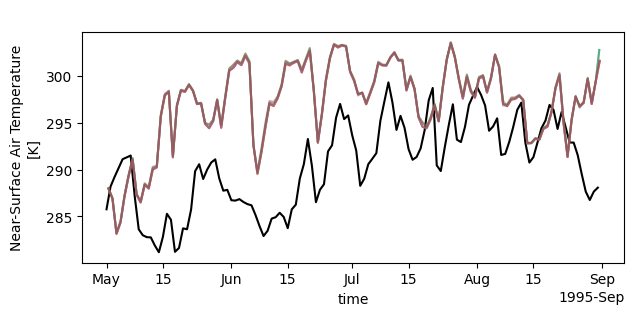

In [14]:
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")
    
    if variable == "tasmax":
        ds_obs = ds_obs.resample(time='1D').max() 
    elif variable == "tasmin":
        ds_obs = ds_obs.resample(time='1D').min() 
    else: 
        ds_obs = ds_obs.resample(time='1D').mean() 

    # select point 
    ds_obs_point = select_point(ds_obs, point_coord)
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output




In [19]:
from valenspy.preprocessing_tasks.select import convert_geo_to_rot


# dictorionary to save data arrays of experiments
d_da_mod_point = {}
for experiment in experiments: 

    # define the CCLM files for the corresponding variable
    if variable == "tasmax": 
        daily_statistic = "max"

    elif variable == "tasmin": 
        daily_statistic = "min"

    else: 
        daily_statistic = "mean"
    
    # load data
    ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])


    # do selection
    point_coord = convert_geo_to_rot(point_coord,ds_mod)
    ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=False)

    da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

    d_da_mod_point[experiment] = da_mod_point

File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


KeyError: "no index found for coordinate 'lon'"

In [6]:
# ------------------------------
# 1. Load reference data


def plot_point_timeseries(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list, ax=False): 
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region="europe")
    
    if variable == "tasmax":
        ds_obs = ds_obs.resample(time='1D').max() 
    elif variable == "tasmin":
        ds_obs = ds_obs.resample(time='1D').min() 
    else: 
        ds_obs = ds_obs.resample(time='1D').mean() 

    # select point 
    ds_obs_point = select_point(ds_obs, point_coord)
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output

    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 

        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"

        elif variable == "tasmin": 
            daily_statistic = "min"

        else: 
            daily_statistic = "mean"
        
        # load data
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])


        # do selection
        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    # when no ax element is passed, create the figure within the function
    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    ax.set_title(da_obs_point.attrs['long_name'], loc='left')

    # only add legend if stand-alone figure
    if not ax: 
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

        
    return ax



def plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=False):

    "Wrapper function to combine 4 point timeseries plot into one figure, with nice layout (legend and title)"
    fig, axes = plt.subplots(2,2,figsize = (16,6))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        ax = plot_point_timeseries(variable, ref_dataset, experiments, d_point_coords[point_id], point_id,  months_to_analyse, ax=ax)

        if i == 1: 
            ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()


### 2m temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/proje

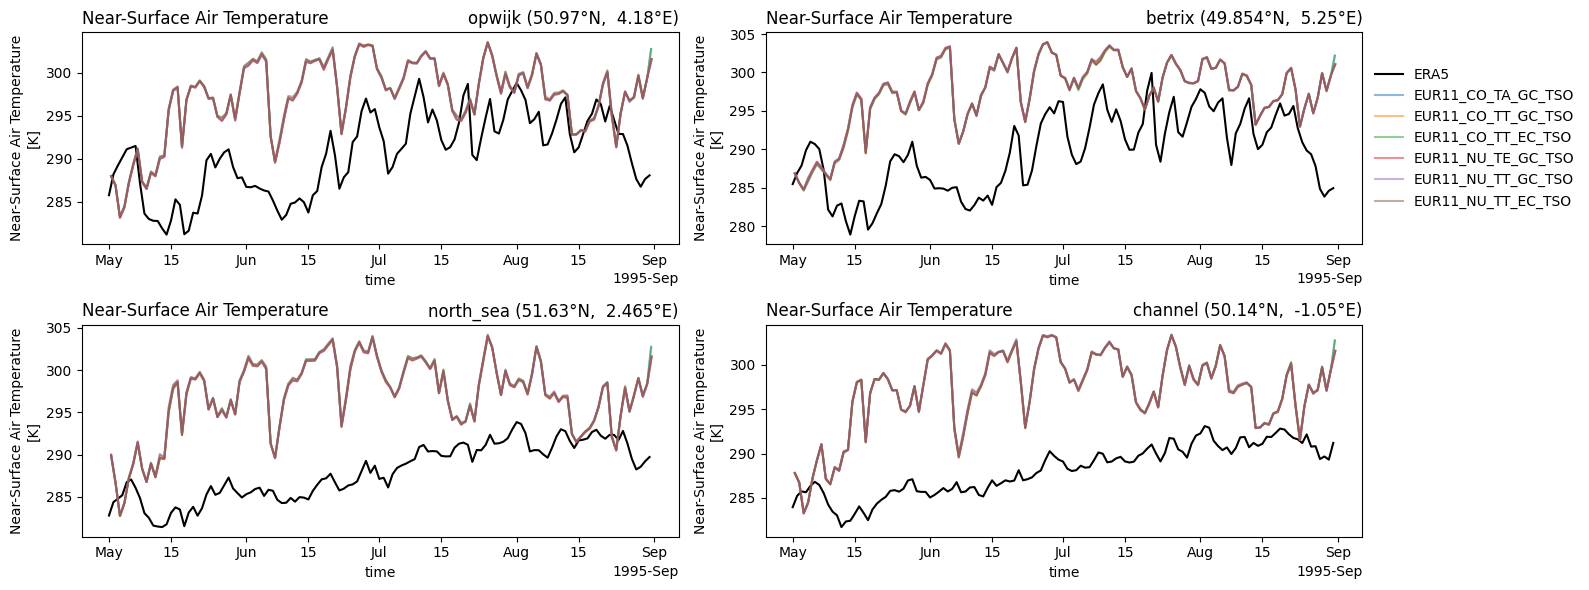

In [4]:
# variables of interest
variable = "tas"
region = 'europe'
ref_dataset = 'ERA5'
months_to_analyse = [5,6,7,8]

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

### Cloudiness

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT_AV/daily/CLCT_AV_daymean.nc
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT/daily/CLCT_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'CLCT_AV']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCT/daily/CLCT_daymean.nc
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCT_AV/daily/CLCT_AV_daymean.nc
Var

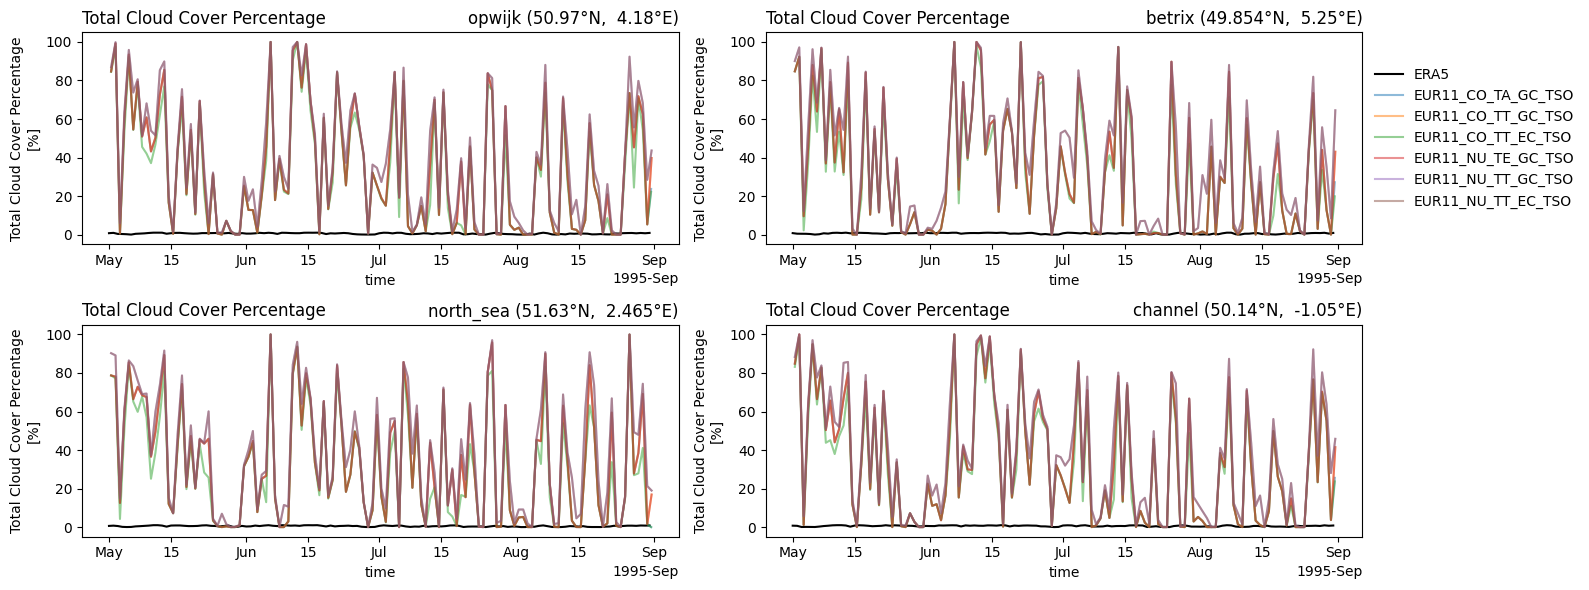

In [5]:
# variables of interest
variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

### Total cloudiness in july

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT_AV/daily/CLCT_AV_daymean.nc
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT/daily/CLCT_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'CLCT_AV']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCT/daily/CLCT_daymean.nc
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCT_AV/daily/CLCT_AV_daymean.nc
Var

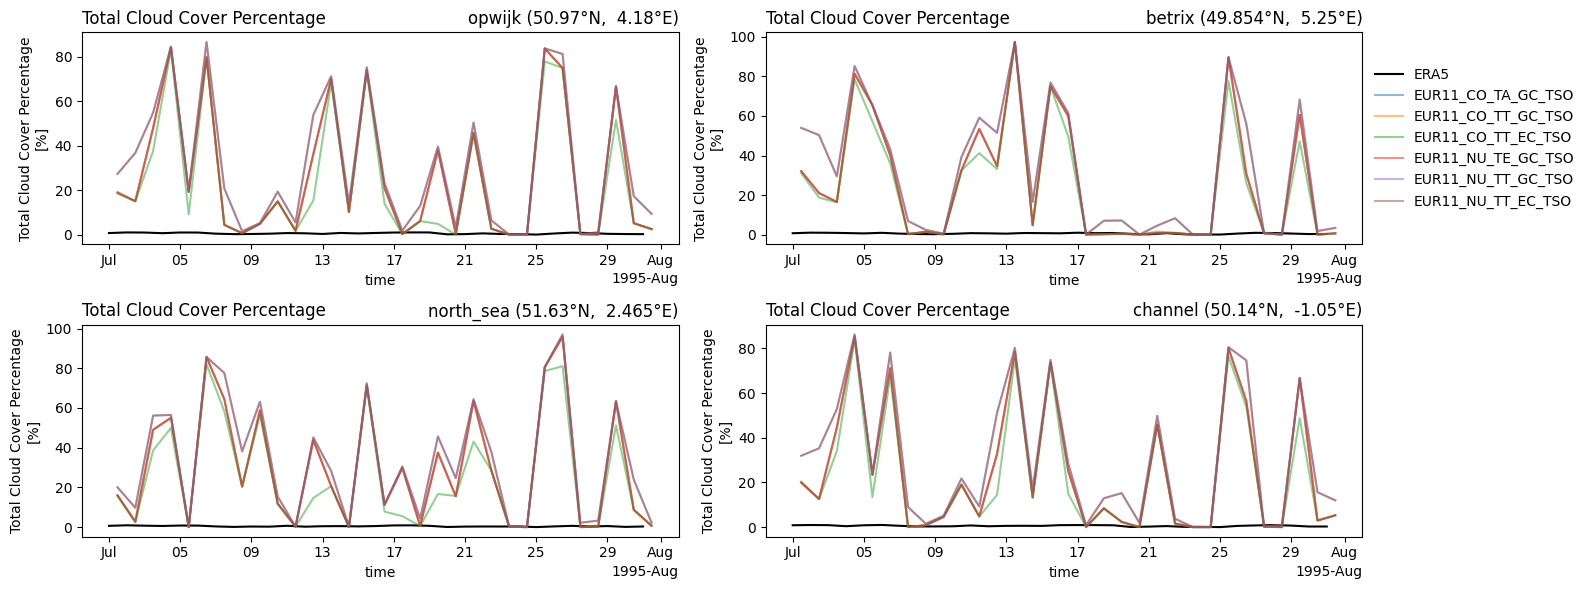

In [6]:
# variables of interest

variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

### Low clouds

In [7]:
# variables of interest

variable = "cll"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCL/daily/CLCL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCL/daily/CLCL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/pro

### medium level clouds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']


File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCM/daily/CLCM_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/CLCM/daily/CLCM_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_EC_TSO/CLCM/daily/CLCM_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
Unknown to ValEnsPy: ['time_bnd

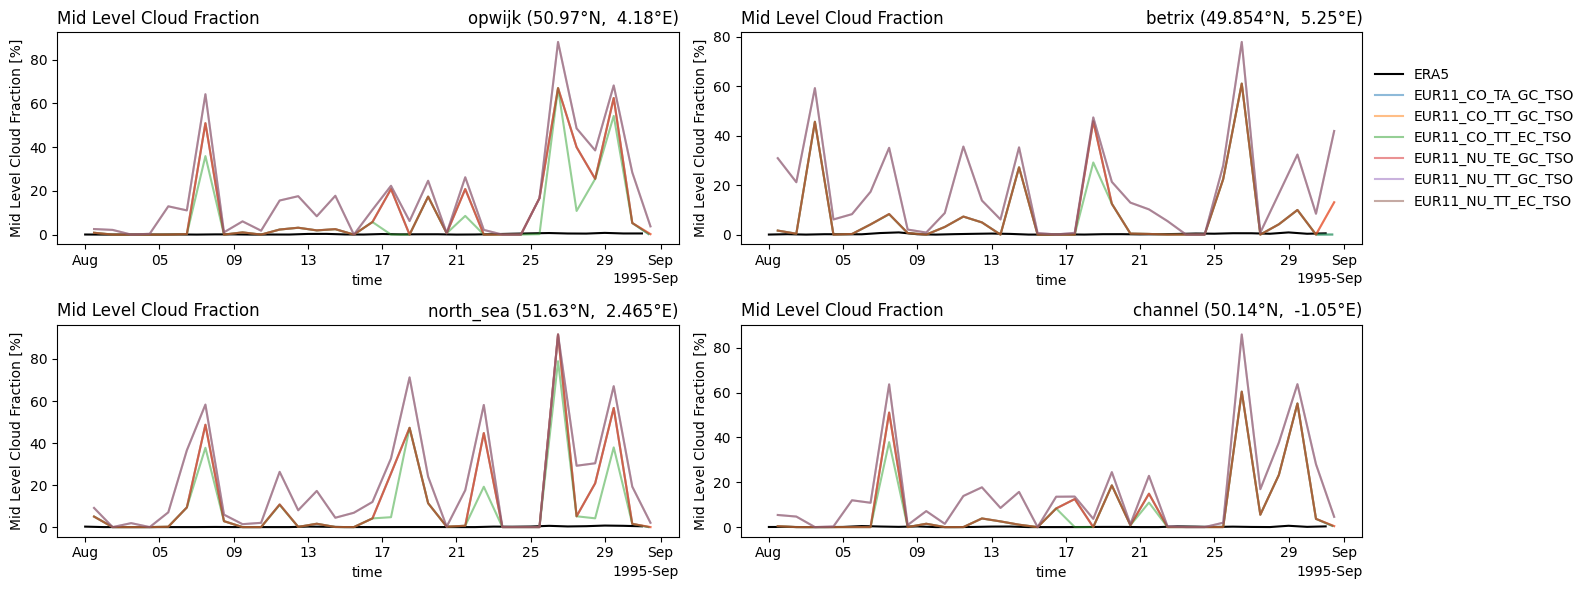

In [ ]:
# variables of interest

variable = "clm"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

### high level clouds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc


AttributeError: 'DataArray' object has no attribute 'time'

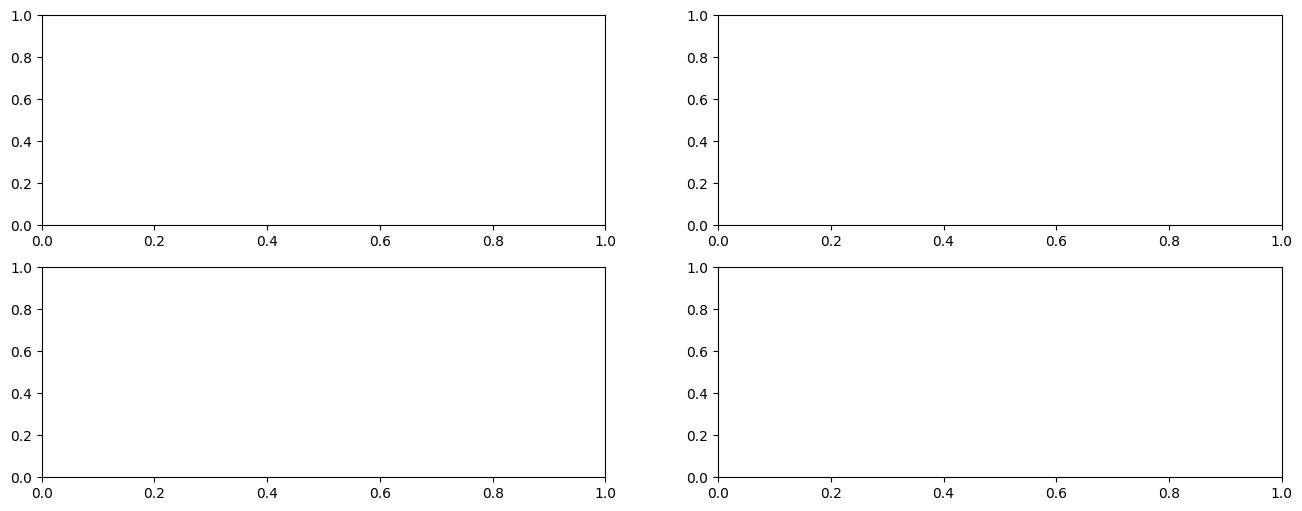

In [ ]:
# variables of interest

variable = "clh"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

### Sea level pressure

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/mean_sea_level_pressure/era5-hourly-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/PMSL/daily/PMSL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/PMSL/daily/PMSL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/

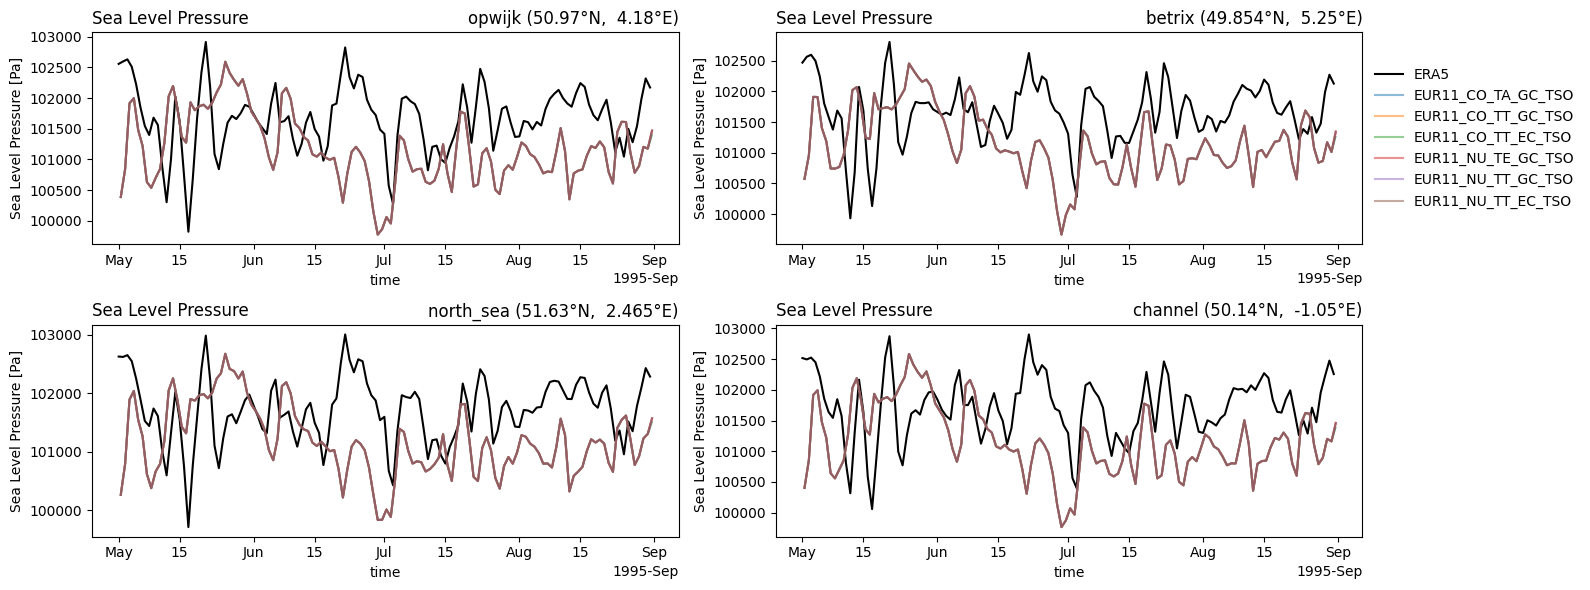

In [11]:
# variables of interest
variable = "psl"
region = 'belgium'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

### Precipitation -- units are not yet correct!!!


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['pr']
The following attributes are missing or incorrect for the variable pr:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           m                         kg m-2 s-1               
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['pr']
The following attributes 

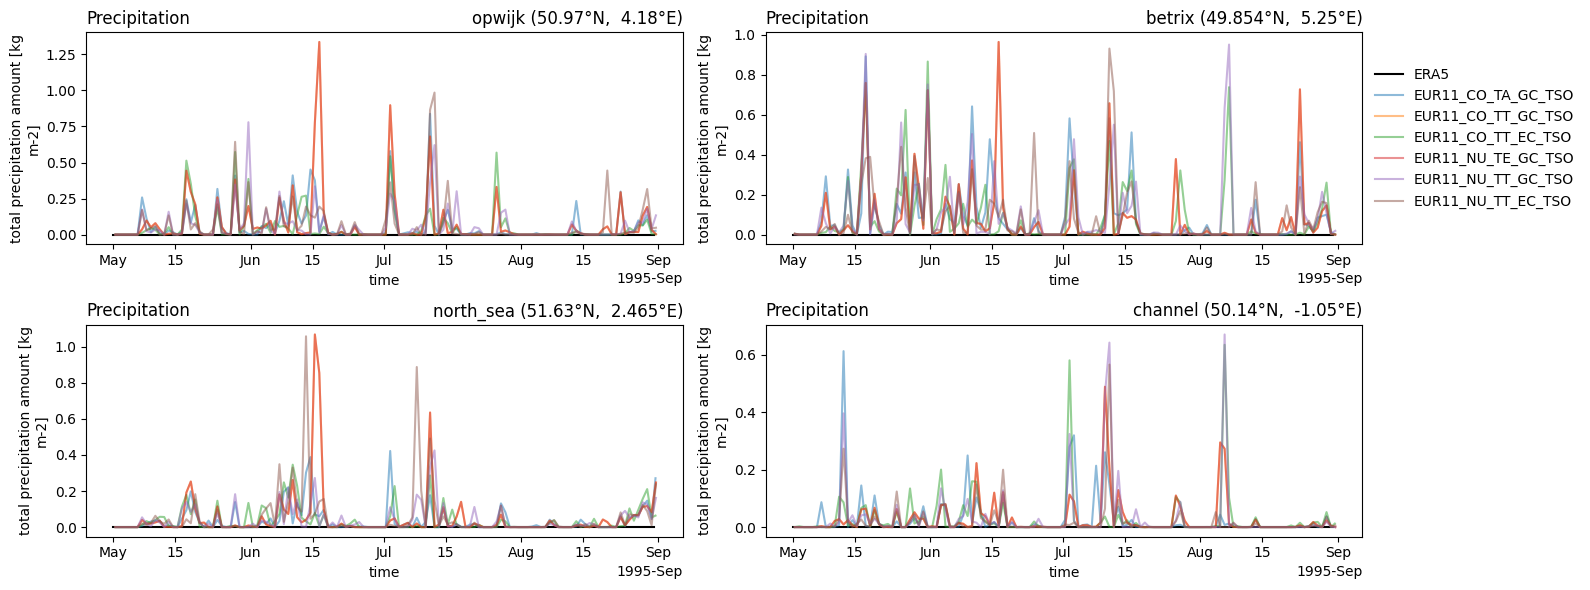

In [ ]:
# variables of interest
variable = "pr"
region = 'europe'
ref_dataset = "ERA5"
unit_conversion = "pr"
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion)

### Latent heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfls']
The following attributes are missing or incorrect for the variable hfls:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    


did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfls']
The following attributes are missing or incorrect for the variable hfls:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF c

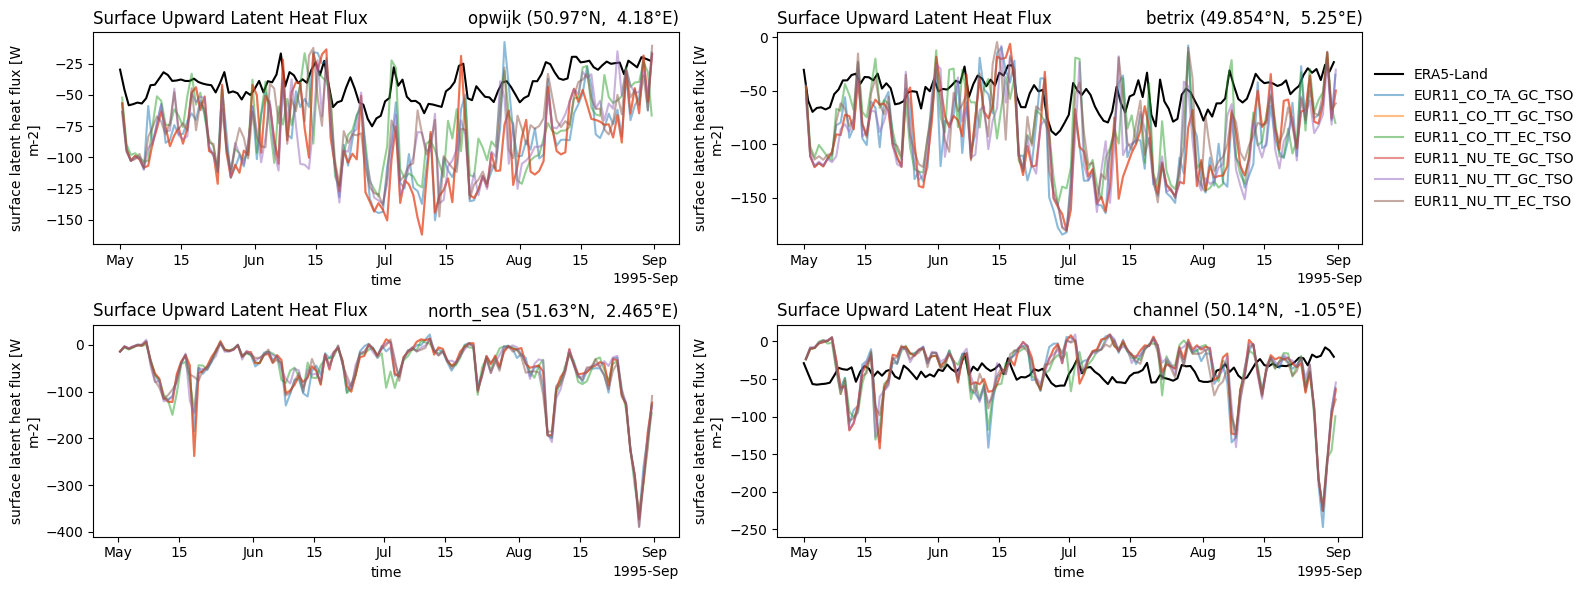

In [ ]:
# variables of interest
variable = "hfls"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

### Sensible heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfss']
The following attributes are missing or incorrect for the variable hfss:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT

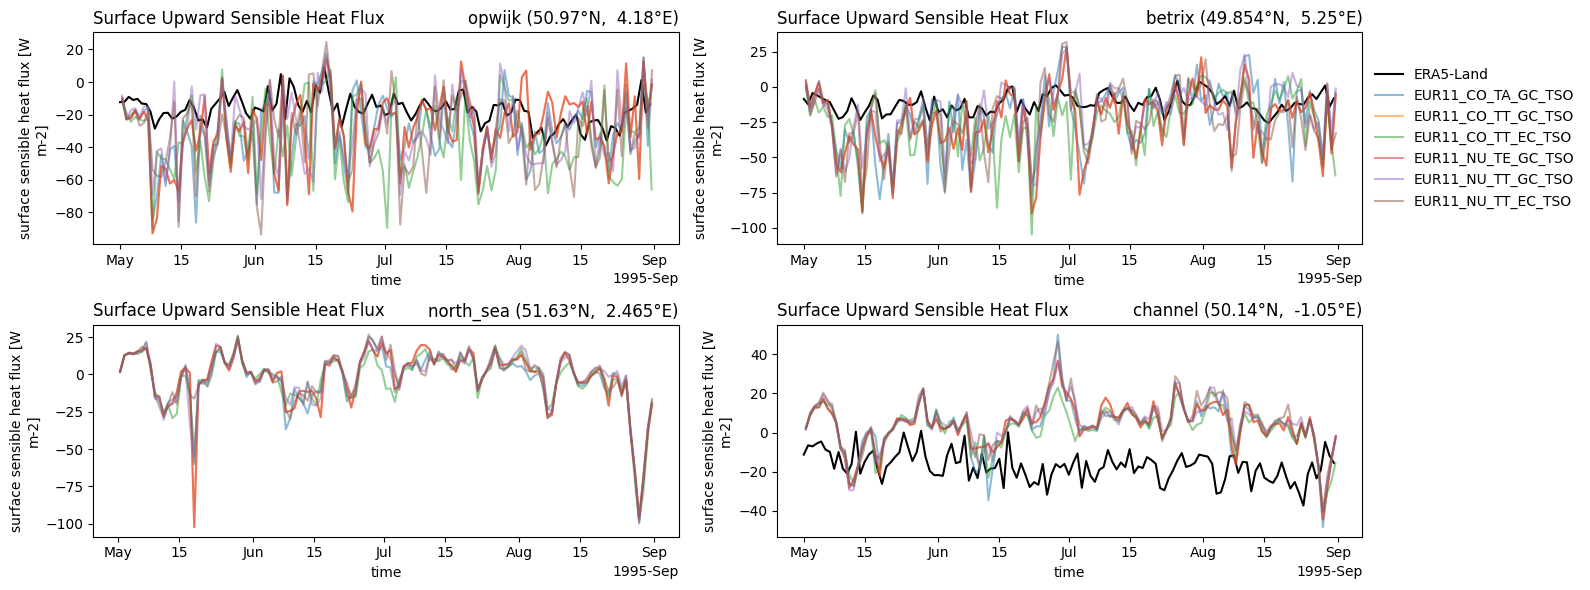

In [ ]:
# variables of interest
variable = "hfss"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

### Surface temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly

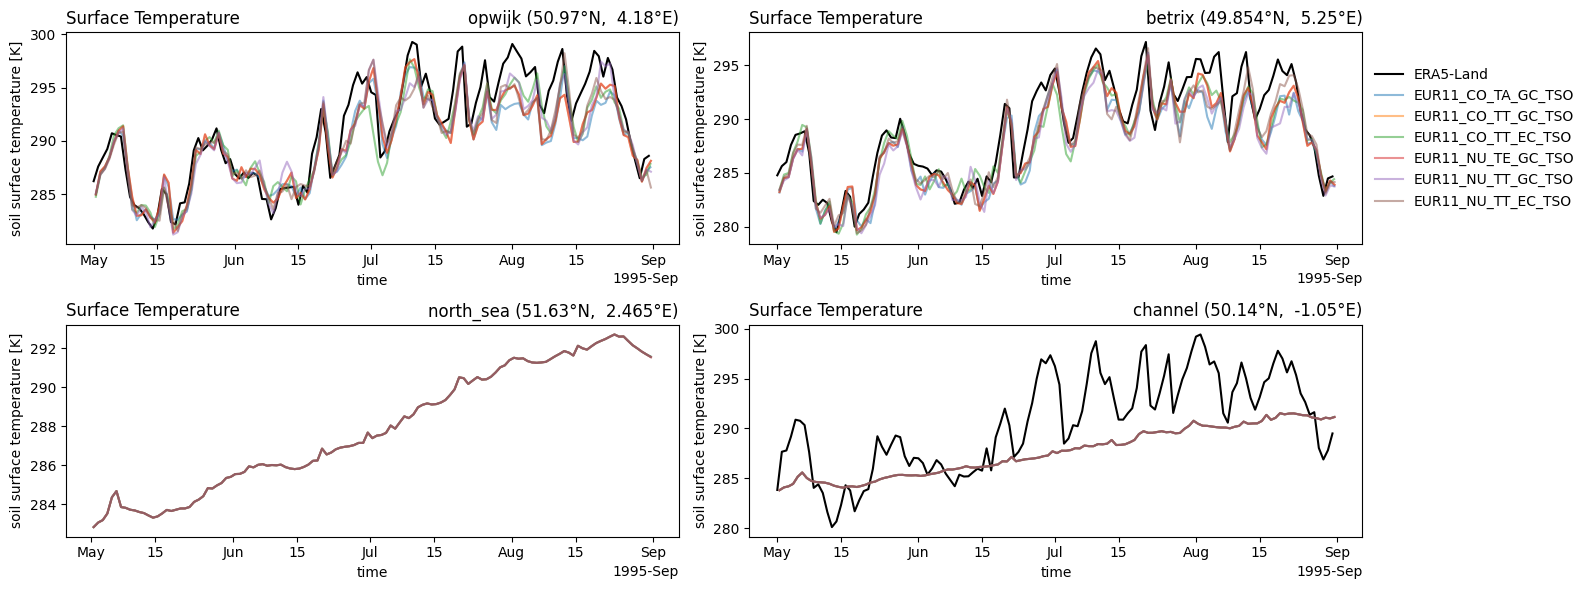

In [20]:
# variables of interest
variable = "ts"
region = 'belgium'
ref_dataset = 'ERA5-Land'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

## Points location on a map

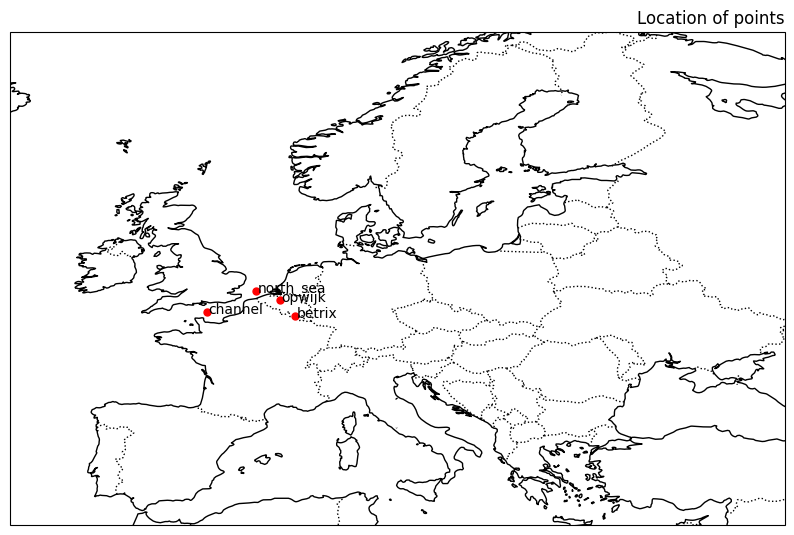

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'europe'

def plot_points_map(d_coord_points: dict, region: str, bounds: str): 

    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot each point and add a label
    for key, (lon, lat) in d_coord_points.items():
        ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat - 0.1, key, transform=ccrs.PlateCarree())

    # Set extent if needed (optional)
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    ax.set_title('Location of points', loc='right')
    # Show the plot
    plt.show()
    fig.savefig("./plots/points_map.png")


plot_points_map(d_coord_points, region, bounds)